In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
import time
import random
import os
import gc
from glob import glob
from PIL import Image
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.optim import Adam
import torch.nn.init as init
import torchvision.transforms.functional as TF

import nibabel as nib  # to read NIFTI file
from sklearn.model_selection import KFold, StratifiedKFold
from nibabel.testing import data_path
import tempfile
import seaborn as sns
import pydicom as dicom
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm
import time
import random
import os
from PIL import Image
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

import timm 
from skimage.transform import rotate
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision import utils
import torch.optim as optim
from torch.optim import Adam
import torch.nn.init as init
import torchvision.transforms.functional as TF

import albumentations
from pylab import rcParams
import torch.cuda.amp as amp
import segmentation_models_pytorch as smp
from monai.transforms import Resize
import  monai.transforms as transforms

In [2]:
segfile_dir = "./segmentations"
trainfile_dir = "./train_images"

model_dir = './clas_models/'
log_dir = './clas_log/'
clas_in_dir = "./clas_in/"

image_size = 224
num_slices = 16
num_organs = 5
in_chans = 7

backbone = 'tf_efficientnetv2_s_in21ft1k'
kernel_type = "0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep"
init_lr = 23e-5
out_dim = 1
eta_min = 23e-6
drop_rate = 0.
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order_v1 = 0.2

n_folds = 5
use_amp = True

### Dataframe 

In [3]:
train_df = pd.read_csv('train.csv') 
train_series_meta_df = pd.read_csv('train_series_meta.csv')
test_series_meta_df = pd.read_csv('test_series_meta.csv')
image_level_labels_df = pd.read_csv('image_level_labels.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

In [4]:
train_df

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,9951,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3143,9960,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3144,9961,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3145,9980,1,0,1,0,1,0,0,1,0,0,0,0,1,1


In [5]:
sample_submission_df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [6]:
#TODO
clas_train_df = train_df.merge(train_series_meta_df, on='patient_id', how='left')
clas_train_df = clas_train_df.drop(['bowel_injury','extravasation_injury','kidney_low','kidney_high', 'liver_low', 'liver_high','spleen_low', 'spleen_high' ,'any_injury', 'aortic_hu', 'incomplete_organ'], axis=1)

In [7]:
clas_train_df

,patient_id,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy,series_id
0,10004,1,0,0,1,0,21057
1,10004,1,0,0,1,0,51033
2,10005,1,1,1,1,1,18667
3,10007,1,1,1,1,1,47578
4,10026,1,1,1,1,1,29700
...,...,...,...,...,...,...,...
4706,9961,1,1,1,1,1,2003
4707,9961,1,1,1,1,1,63032
4708,9980,1,1,1,1,0,40214
4709,9980,1,1,1,1,0,40466


In [8]:
clas_train_df = clas_train_df.drop(['patient_id'], axis=1)

In [9]:
clas_train_df

,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy,series_id
0,1,0,0,1,0,21057
1,1,0,0,1,0,51033
2,1,1,1,1,1,18667
3,1,1,1,1,1,47578
4,1,1,1,1,1,29700
...,...,...,...,...,...,...
4706,1,1,1,1,1,2003
4707,1,1,1,1,1,63032
4708,1,1,1,1,0,40214
4709,1,1,1,1,0,40466


In [10]:
# k-fold
kf = KFold(n_splits=5, shuffle=True)

for i, (_, v_ind) in enumerate(kf.split(clas_train_df)):
    clas_train_df.loc[clas_train_df.index[v_ind], 'kfold'] = i
#print(clas_train_df.to_string())
clas_train_df

,bowel_healthy,extravasation_healthy,kidney_healthy,liver_healthy,spleen_healthy,series_id,kfold
0,1,0,0,1,0,21057,1.0
1,1,0,0,1,0,51033,3.0
2,1,1,1,1,1,18667,2.0
3,1,1,1,1,1,47578,3.0
4,1,1,1,1,1,29700,2.0
...,...,...,...,...,...,...,...
4706,1,1,1,1,1,2003,2.0
4707,1,1,1,1,1,63032,1.0
4708,1,1,1,1,0,40214,0.0
4709,1,1,1,1,0,40466,1.0


In [11]:
train_clmns = ['bowel_healthy','extravasation_healthy','kidney_healthy','liver_healthy','spleen_healthy']

series_id = []
organ_index = []
label = []
kf = []

for _, row in clas_train_df.iterrows():
    for oi, clmn in enumerate(train_clmns):
        series_id.append(int(row.series_id))
        organ_index.append(oi)
        label.append(int(row[f'{clmn}']))
        kf.append(int(row.kfold))
        

df = pd.DataFrame({
    'series_id': series_id,
    'oid': organ_index,
    'label': label,
    'kfold': kf
})

df

,series_id,oid,label,kfold
0,21057,0,1,1
1,21057,1,0,1
2,21057,2,0,1
3,21057,3,1,1
4,21057,4,0,1
...,...,...,...,...
23550,10806,0,1,0
23551,10806,1,1,0
23552,10806,2,1,0
23553,10806,3,1,0


In [12]:
transforms_train = albumentations.Compose([
    
    albumentations.Resize(image_size, image_size),
    
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.RandomBrightness(limit=0.1, p=0.7),
    #albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),
    
    #albumentations.OneOf([
    #    albumentations.MotionBlur(blur_limit=3),
    #    albumentations.MedianBlur(blur_limit=3),
    #    albumentations.GaussianBlur(blur_limit=3),
    #    albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    #], p=0.5),
    
    #albumentations.OneOf([
    #    albumentations.OpticalDistortion(distort_limit=1.),
    #    albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    #], p=0.5),
 
    #albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),

    
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

In [13]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df #.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        images = []
        
        tmp = list(range(5))
        ### random order v3
        #if self.mode == 'train' and random.random() < p_rand_order:
        #    random.shuffle(tmp)
        ###
        for organ_index in (tmp):
            for slice_index in list(range(num_slices)):
                crop_clas_in_dir = clas_in_dir+ '/'+ str(int(10180)) +'/' 
                crop_clas_in_path = crop_clas_in_dir + "organ_id_"+ str(organ_index) +'_'+ "slice_id_"+  str(slice_index)+ '.npy'
                #print(crop_clas_in_path)
                image = np.load(crop_clas_in_path)      
                ##TODO
                image = self.transform(image=image)['image']
                image = image.transpose(2, 0, 1).astype(np.float32) / 255. 
                
                '''
                #display sample images for channels
                for i in range(1):
                    plt.imshow(image[5,:,:]) 
                    plt.show()
                '''  
                
                images.append(image)
        #print(len(images))
                
        images = np.stack(images, 0)        

        if self.mode != 'test':
            labels = []
            clmns = ['bowel_healthy','extravasation_healthy','kidney_healthy','liver_healthy','spleen_healthy']
            for c_name in clmns:
                temp = [row[c_name]] * num_slices
                labels += [row[c_name]] * num_slices
                
            images = torch.tensor(images).float()
            labels = torch.tensor(labels).float()

            return images, labels
                
        else:
            return torch.tensor(images).float()

In [14]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df#.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        #print(row)
        oid = row.oid
        
        images = []
        
        for slice_index in list(range(num_slices)):
            crop_clas_in_dir = clas_in_dir+ '/'+ str(int(10180)) +'/' 
            crop_clas_in_path = crop_clas_in_dir + "organ_id_"+ str(oid) +'_'+ "slice_id_"+  str(slice_index)+ '.npy'
            image = np.load(crop_clas_in_path)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.  
            images.append(image)
            
        images = np.stack(images, 0)

        if self.mode != 'test':
            images = torch.tensor(images).float()
            labels = torch.tensor([row.label] * num_slices).float()
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]

            return images, labels
        else:
            return torch.tensor(images).float()

In [15]:
#images
#(num_organ*num_slices,num_chan,img_x,img_y)

In [16]:
cd = CLSDataset(df,"train",transforms_train)

In [17]:

i = 0 
for images, labels in cd:
    print(images.shape, labels.shape)
    i+=1
    if i ==1:
        break


torch.Size([16, 7, 224, 224]) torch.Size([16])


In [18]:
#images                                               labels
#(num_organ*num_slices,num_chan,img_x,img_y)          num_organ*num_slices

In [19]:

rcParams['figure.figsize'] = 20,8
batch_size = 1 

df_show = df
dataset_show = CLSDataset(df, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(df, batch_size=batch_size, shuffle=True, num_workers=0)


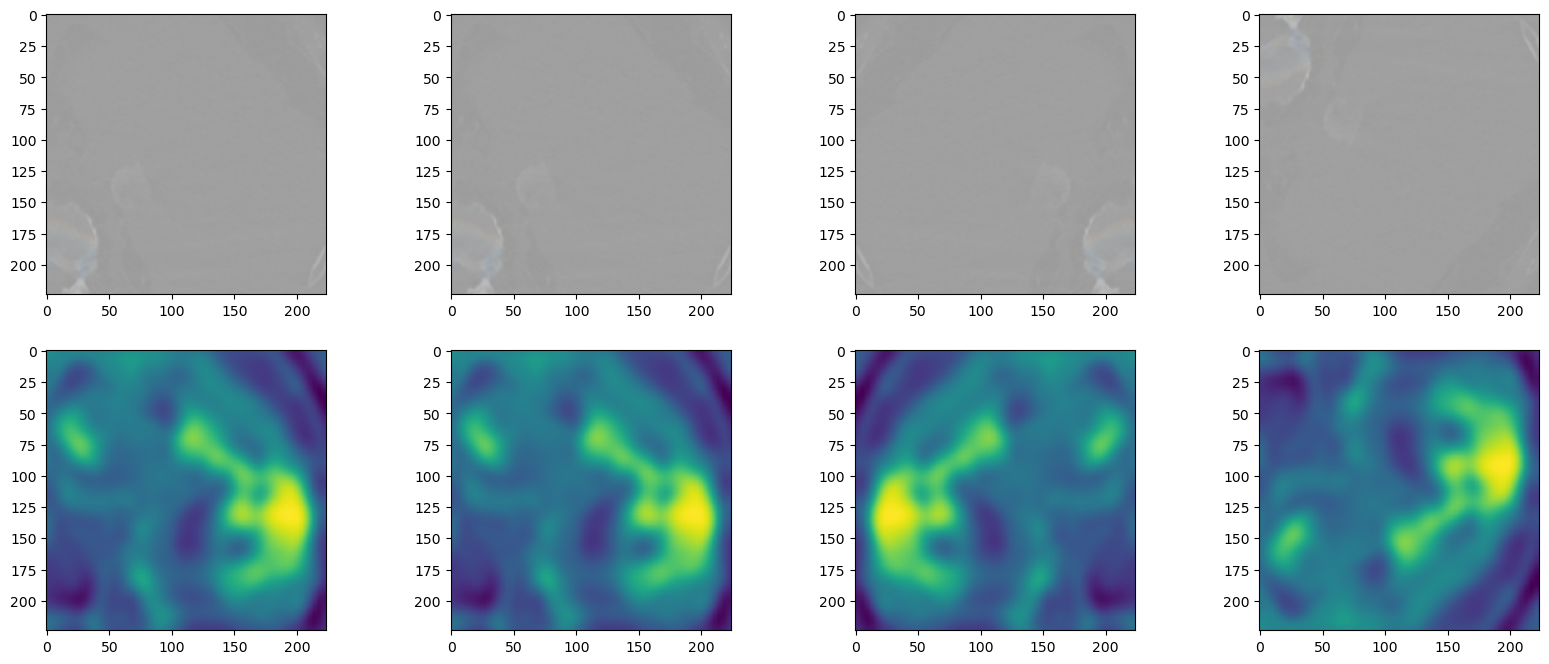

In [20]:
f, axarr = plt.subplots(2,4)
for p in range(4):
    idx = p * 20
    imgs, lbl = dataset_show[idx]
    axarr[0, p].imshow(imgs[7][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[7][-1])


### Model

In [21]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()


        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * num_slices, in_chans, image_size, image_size)
        #print(x.shape)
        feat = self.encoder(x)
        feat = feat.view(bs, num_slices, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * num_slices, -1)
        feat = self.head(feat)
        feat = feat.view(bs, num_slices).contiguous()

        return feat

In [22]:
#TODO

m = TimmModel(backbone)
m(torch.rand(1, num_slices, in_chans, image_size, image_size)).shape


torch.Size([1, 16])

### Loss & Metric

In [23]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

### Train & Valid func

In [54]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    print("c")
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        print("a")
        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    print(len(bar))
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()
            print(images.shape,targets.shape)
            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
    valid_loss = criterion(outputs, gts).item()

    return valid_loss

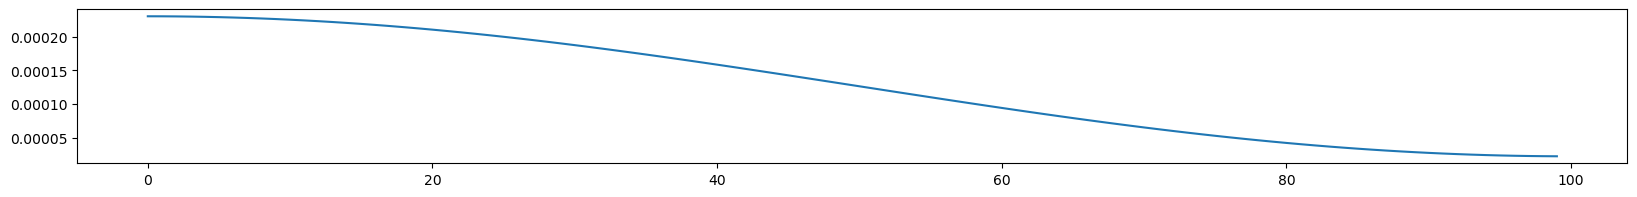

In [55]:
n_epochs = 100

rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

### Train

In [66]:
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [73]:
DEBUG = True
num_workers = 0
batch_size = 1


n_epochs = 1
df = df
device = torch.device('cuda')

In [74]:
df = df.head(1000)

In [75]:
df

,series_id,oid,label,kfold
0,21057,0,1,1
1,21057,1,0,1
2,21057,2,0,1
3,21057,3,1,1
4,21057,4,0,1
5,51033,0,1,3
6,51033,1,0,3
7,51033,2,0,3
8,51033,3,1,3
9,51033,4,0,3


In [76]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df[df['kfold'] != fold].reset_index(drop=True)
    valid_ = df[df['kfold'] == fold].reset_index(drop=True)
    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    #print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [77]:
run(1)

777
   series_id  oid  label  kfold
0      21057    0      1      1
1      21057    1      0      1
2      21057    2      0      1
3      21057    3      1      1
4      21057    4      0      1
777
Thu Oct 12 14:20:36 2023 Epoch: 1


smth:0.8879:   7%|████▋                                                                 | 1/15 [00:00<00:01,  7.23it/s]

c
a


smth:0.8892:  20%|██████████████                                                        | 3/15 [00:00<00:01,  7.80it/s]

a
a


smth:0.8109:  33%|███████████████████████▎                                              | 5/15 [00:00<00:01,  7.68it/s]

a
a


smth:0.7402:  47%|████████████████████████████████▋                                     | 7/15 [00:00<00:01,  7.60it/s]

a
a


smth:0.7675:  60%|██████████████████████████████████████████                            | 9/15 [00:01<00:00,  7.73it/s]

a
a


smth:0.7933:  73%|██████████████████████████████████████████████████▌                  | 11/15 [00:01<00:00,  7.72it/s]

a
a


smth:0.7981:  87%|███████████████████████████████████████████████████████████▊         | 13/15 [00:01<00:00,  7.78it/s]

a
a


smth:0.7965: 100%|█████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  7.69it/s]


a
a


smth:0.6835:   0%|                                                                               | 0/5 [00:00<?, ?it/s]

5
torch.Size([1, 16, 7, 224, 224]) torch.Size([1, 16])
torch.Size([1, 16, 7, 224, 224]) torch.Size([1, 16])


smth:0.7040:  60%|██████████████████████████████████████████▌                            | 3/5 [00:00<00:00, 23.41it/s]

torch.Size([1, 16, 7, 224, 224]) torch.Size([1, 16])
torch.Size([1, 16, 7, 224, 224]) torch.Size([1, 16])


smth:0.7050: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.27it/s]


torch.Size([1, 16, 7, 224, 224]) torch.Size([1, 16])
Thu Oct 12 14:20:38 2023 Fold 1, Epoch 1, lr: 0.0002300, train loss: 0.79651, valid loss: 0.70103, metric: 0.701028.
metric_best (inf --> 0.701028). Saving model ...
